In [1]:
import requests
import pandas as pd
from collections import defaultdict
from itertools import combinations
import networkx as nx
import time
import netwulf as nw
import matplotlib.pyplot as plt
import numpy as np

C:\Users\canic\AppData\Local\Temp\ipykernel_27956\4239115370.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def read_csv_file(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Failed to read CSV: {e}")
        return None

In [3]:
charachters = read_csv_file("filtered_charachter_info.csv")
charachters

,name,type,species,affiliation,gender,pronouns,hair,skin,homeworld,death,location,eyes,class
0,"""Changeling"" Mark 71NB",Racing starfighter,NaN,Ace Squadron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TIE/ba Baron Space Superiority Interceptor,Starfighter,NaN,First Order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"""Impact"" repulsor cannon",Repulsor cannon,NaN,Law enforcement agencies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"""Peacekeeper"" stun baton",Stun baton,NaN,Galactic Empire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"""Renegade"" heavy blaster pistol",Heavy blaster pistol,NaN,Alliance to Restore the Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,Unidentified maintenance droid 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"c. 232 BBY, Steady Wing, Haileap",NaN,NaN,Maintenance droid
20528,Unidentified protocol droid (Suli's cantina),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"29 ABY, Chaaktil",NaN,NaN,Protocol droid
20529,Unidentified RA-7 protocol droid (Nar Shaddaa),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 ABY,NaN,NaN,Protocol droid
20530,Unidentified service droid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,During the skirmish aboard the Sorca Retreat,NaN,NaN,Service droid


In [4]:
def call_api(url, params=None, headers=None, method="GET", data=None):
    try:
        response = requests.request(method, url, params=params, headers=headers, json=data)
        response.raise_for_status()  # Raises HTTPError for bad responses
        return response.json()  # or response.text if it's not JSON
    except requests.RequestException as e:
        print(f"API call failed: {e}")
        return None

In [5]:
url = "https://swapi.info/api/people"
response_data = call_api(url)
response_data

[{'name': 'Luke Skywalker',
  'height': '172',
  'mass': '77',
  'hair_color': 'blond',
  'skin_color': 'fair',
  'eye_color': 'blue',
  'birth_year': '19BBY',
  'gender': 'male',
  'homeworld': 'https://swapi.info/api/planets/1',
  'films': ['https://swapi.info/api/films/1',
   'https://swapi.info/api/films/2',
   'https://swapi.info/api/films/3',
   'https://swapi.info/api/films/6'],
  'species': [],
  'vehicles': ['https://swapi.info/api/vehicles/14',
   'https://swapi.info/api/vehicles/30'],
  'starships': ['https://swapi.info/api/starships/12',
   'https://swapi.info/api/starships/22'],
  'created': '2014-12-09T13:50:51.644000Z',
  'edited': '2014-12-20T21:17:56.891000Z',
  'url': 'https://swapi.info/api/people/1'},
 {'name': 'C-3PO',
  'height': '167',
  'mass': '75',
  'hair_color': 'n/a',
  'skin_color': 'gold',
  'eye_color': 'yellow',
  'birth_year': '112BBY',
  'gender': 'n/a',
  'homeworld': 'https://swapi.info/api/planets/1',
  'films': ['https://swapi.info/api/films/1',
 

In [6]:
# Make the API call
url = "https://swapi.info/api/people"
response = call_api(url)

# Define mapping from API to CSV
api_to_csv_map = {
    "name": "name",
    "species": "species",          
    "gender": "gender",
    "hair_color": "hair",
    "skin_color": "skin",
    "homeworld": "homeworld",        
    "eye_color": "eyes"
}

n = 0
c = 0
# Loop through characters from API and update CSV (we know we have a API response)
for char in response:
    name = char.get("name")
    if name in charachters["name"].values:
        print(f"{name} found in CSV.")
        n += 1

        idx = charachters[charachters["name"] == name].index[0]

        for api_field, csv_field in api_to_csv_map.items():
            current_value = charachters.at[idx, csv_field]

            # Only update if CSV field is missing or empty
            if pd.isna(current_value) or current_value == "":
                value = char.get(api_field)
                print(f"Updating {csv_field} for {name}: {value}")
                c+=1

                # Convert lists (like species) to string
                if isinstance(value, list):
                    value = ", ".join(value)

                if value:
                    charachters.at[idx, csv_field] = value

print(f"------------- \n {n} characters updated in CSV.")
print(f"------------- \n {c} values updated in CSV.")

Luke Skywalker found in CSV.
C-3PO found in CSV.
Updating species for C-3PO: ['https://swapi.info/api/species/2']
Updating hair for C-3PO: n/a
Updating skin for C-3PO: gold
Updating eyes for C-3PO: yellow
R2-D2 found in CSV.
Updating species for R2-D2: ['https://swapi.info/api/species/2']
Updating hair for R2-D2: n/a
Updating skin for R2-D2: white, blue
Updating eyes for R2-D2: red
Owen Lars found in CSV.
R5-D4 found in CSV.
Updating species for R5-D4: ['https://swapi.info/api/species/2']
Updating gender for R5-D4: n/a
Updating hair for R5-D4: n/a
Updating skin for R5-D4: white, red
Updating homeworld for R5-D4: https://swapi.info/api/planets/1
Updating eyes for R5-D4: red
Biggs Darklighter found in CSV.
Obi-Wan Kenobi found in CSV.
Anakin Skywalker found in CSV.
Wilhuff Tarkin found in CSV.
Chewbacca found in CSV.
Updating skin for Chewbacca: unknown
Han Solo found in CSV.
Greedo found in CSV.
Updating hair for Greedo: n/a
Jabba Desilijic Tiure found in CSV.
Updating hair for Jabba De

In [8]:
charachters.to_csv('Refined_characters.csv', index=False)

---

Følgende kode er langsom til at lave edge list

In [7]:
def create_edge_list_from_sparse_df(df, columns):
    """
    Create an edge list based on shared attributes in specified columns.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): List of column names to consider for edges.

    Returns:
        List of tuples: Each tuple is of the form (row1, row2, shared_attributes).
    """
    edges = []
    
    # Iterate over all pairs of rows
    for (idx1, row1), (idx2, row2) in combinations(df.iterrows(), 2):
        shared_attributes = []
        
        # Check for shared non-empty values in the specified columns
        for col in columns:
            if pd.notna(row1[col]) and pd.notna(row2[col]) and row1[col] == row2[col]:
                shared_attributes.append(col)
        
        # If there are shared attributes, create an edge
        if shared_attributes:
            edges.append((idx1, idx2, shared_attributes))
    
    return edges

# Example usage
columns_of_interest = ["name","type","species", "affiliation", "homeworld","death","eyes","hair"]
edge_list = create_edge_list_from_sparse_df(charachters[:100], columns_of_interest)

# Print or save the edge list
print(edge_list)

[(1, 8, ['affiliation']), (1, 16, ['type']), (1, 17, ['type']), (1, 18, ['type']), (1, 20, ['affiliation']), (1, 48, ['affiliation']), (1, 67, ['type']), (1, 80, ['affiliation']), (1, 88, ['type']), (1, 92, ['type']), (1, 93, ['type']), (1, 97, ['type']), (3, 6, ['affiliation']), (3, 7, ['affiliation']), (3, 16, ['affiliation']), (3, 17, ['affiliation']), (3, 18, ['affiliation']), (3, 19, ['affiliation']), (3, 21, ['affiliation']), (3, 22, ['affiliation']), (3, 25, ['affiliation']), (3, 30, ['affiliation']), (3, 31, ['affiliation']), (3, 41, ['affiliation']), (3, 45, ['affiliation']), (3, 51, ['affiliation']), (3, 52, ['affiliation']), (3, 59, ['affiliation']), (3, 62, ['affiliation']), (3, 70, ['affiliation']), (3, 72, ['affiliation']), (3, 83, ['affiliation']), (3, 86, ['affiliation']), (3, 87, ['affiliation']), (3, 98, ['affiliation']), (3, 99, ['affiliation']), (4, 5, ['affiliation']), (4, 9, ['affiliation']), (4, 10, ['affiliation']), (4, 15, ['affiliation']), (4, 24, ['affiliatio

Gemini 2.5 advanced har forbedret running time fra O(N^2 * M) til 
$$
∑ 
_{col∈M}
​
 ∑ 
_{group∈col}
​
 O(k_{group} ^
2)$$ 
, where k 
group
​
  is the size of a group. This is typically much faster than O(N 
2
 ×M).

In [8]:
# import pandas as pd
# from itertools import combinations
# from collections import defaultdict
# import time # To measure execution time

# def create_edge_list_optimized(df, columns):
#     """
#     Create an edge list based on shared attributes using a grouping approach.
#     Expected to be significantly faster for large DataFrames.

#     Parameters:
#         df (pd.DataFrame): The DataFrame containing the data.
#         columns (list): List of column names to consider for edges.

#     Returns:
#         List of tuples: Each tuple is of the form (row1_idx, row2_idx, shared_attributes).
#     """
#     start_time = time.time()
#     # Use a defaultdict to store shared attributes for each pair of indices
#     # Key: tuple(sorted((idx1, idx2))) to ensure uniqueness regardless of order
#     # Value: list of shared column names
#     # Using defaultdict avoids checking if the key exists before appending
#     edge_dict = defaultdict(list)

#     print(f"Optimized edge list creation started for {len(df)} rows and {len(columns)} columns.")

#     # Make sure indices are unique if they aren't already
#     if not df.index.is_unique:
#         print("Warning: DataFrame index is not unique. Resetting index.")
#         df = df.reset_index() # Keep original index if needed or drop=True

#     total_columns = len(columns)
#     for i, col in enumerate(columns):
#         col_start_time = time.time()
#         print(f"  Processing column '{col}' ({i+1}/{total_columns})... ", end="")

#         # --- Core Logic ---
#         # 1. Drop rows where the current column is NaN
#         # 2. Group by the value in the current column
#         # 3. For each group, get the list of original indices
#         # We use .loc to potentially avoid warnings and work on relevant data
#         # Directly getting 'index' and 'col' can be more memory efficient
#         try:
#             # Create a temporary series mapping index to column value, dropping NaNs
#             col_data = df[col].dropna()

#             # Group by the column value and get lists of indices for each value
#             # Using .indices directly from groupby is often efficient
#             grouped_indices = col_data.groupby(col_data).indices

#             # 4. Iterate through groups that have more than one member
#             potential_pairs_count = 0
#             for value, indices in grouped_indices.items():
#                 if len(indices) > 1:
#                     # 5. Generate all pairs of indices within this group
#                     for idx1, idx2 in combinations(indices, 2):
#                         # 6. Add the current column to the shared attributes for this pair
#                         key = tuple(sorted((idx1, idx2))) # Use sorted tuple as key
#                         edge_dict[key].append(col)
#                         potential_pairs_count += 1
#             # --- End Core Logic ---

#             col_end_time = time.time()
#             print(f"Found {potential_pairs_count} potential pairs. Took {col_end_time - col_start_time:.2f}s. Edge dict size: {len(edge_dict)}")

#         except KeyError:
#              print(f"Column '{col}' not found in DataFrame. Skipping.")
#         except Exception as e:
#              print(f"An error occurred processing column '{col}': {e}")


#     print("Consolidating edge list...")
#     # Convert the dictionary to the desired list format
#     edge_list = [(key[0], key[1], shared_cols) for key, shared_cols in edge_dict.items()]

#     end_time = time.time()
#     print(f"Finished creating edge list. Total time: {end_time - start_time:.2f} seconds.")
#     return edge_list

# # --- Example Usage ---
# # Assuming 'characters' is your DataFrame with ~32000 rows
# # Make sure pandas is imported: import pandas as pd
# # characters = pd.read_csv('your_data.csv') # Load your data

# columns_of_interest = ["name","type","species", "affiliation", "homeworld","death","eyes","hair"]

# # Run the optimized function
# edge_list_optimized = create_edge_list_optimized(charachters, columns_of_interest)

# print(f"Generated {len(edge_list_optimized)} edges.")
# # print(edge_list_optimized[:10]) # Print first 10 edges to check

In [9]:
def create_edge_list_optimized(df, columns):
    """
    Create a weighted edge list based on shared attributes using a
    grouping approach. The weight represents the number of shared attributes.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): List of column names to consider for edges.

    Returns:
        List of tuples: Each tuple is of the form
                        (row1_idx, row2_idx, weight, shared_attributes_list).
    """
    start_time = time.time()
    edge_dict = defaultdict(list)

    print(f"Optimized edge list creation started for {len(df)} rows and {len(columns)} columns.")

    # Ensure index is unique if needed (important for referencing rows)
    if not df.index.is_unique:
        print("Warning: DataFrame index is not unique. Consider resetting index if issues arise.")
        # Option: df = df.reset_index() # Uncomment if you need a guaranteed unique 0-based index

    total_columns = len(columns)
    for i, col in enumerate(columns):
        col_start_time = time.time()
        print(f"  Processing column '{col}' ({i+1}/{total_columns})... ", end="")

        try:
            # Create a series mapping index to column value, dropping NaNs
            col_data = df[col].dropna()
            if col_data.empty:
                print("No valid data. Skipped.")
                continue

            # Group by the column value and get lists of indices for each value
            grouped_indices = col_data.groupby(col_data).indices

            potential_pairs_count = 0
            # Iterate through groups that have more than one member
            for value, indices in grouped_indices.items():
                if len(indices) > 1:
                    # Generate all pairs of indices within this group
                    for idx1, idx2 in combinations(indices, 2):
                        # Use sorted tuple of indices as key
                        key = tuple(sorted((idx1, idx2)))
                        # Add the current column to the list of shared attributes for this pair
                        edge_dict[key].append(col)
                        potential_pairs_count += 1

            col_end_time = time.time()
            print(f"Found {potential_pairs_count} potential pairs. Took {col_end_time - col_start_time:.2f}s. Edge dict size: {len(edge_dict)}")

        except KeyError:
             print(f"Column '{col}' not found in DataFrame. Skipping.")
        except Exception as e:
             print(f"An error occurred processing column '{col}': {e}")


    print("\nConsolidating edge list with weights (count of shared attributes)...")
    # Create the final list, including the weight (count)
    # Format: (index1, index2, weight, list_of_shared_columns)
    edge_list = [(key[0], key[1], len(shared_cols), shared_cols)
                 for key, shared_cols in edge_dict.items()]

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nFinished creating edge list.")
    print(f"  Generated {len(edge_list)} edges.")
    print(f"  Total time: {total_time:.2f} seconds.")
    return edge_list

# --- How to use it ---

# 2. Define the columns to check for shared attributes
columns_of_interest = ["type", "species", "affiliation", "homeworld", "death", "eyes", "hair"] # Adjust as needed

# 3. Call the function to generate the weighted edges
weighted_edge_list = create_edge_list_optimized(charachters, columns_of_interest)

# 4. Inspect the result
print("\nFirst 10 edges:")
for edge in weighted_edge_list[:10]:
   print(edge)



Optimized edge list creation started for 20532 rows and 7 columns.
  Processing column 'type' (1/7)... Found 88411 potential pairs. Took 0.16s. Edge dict size: 88411
  Processing column 'species' (2/7)... Found 6999070 potential pairs. Took 8.53s. Edge dict size: 7072522
  Processing column 'affiliation' (3/7)... Found 9022853 potential pairs. Took 9.64s. Edge dict size: 15611897
  Processing column 'homeworld' (4/7)... Found 81688 potential pairs. Took 0.06s. Edge dict size: 15675441
  Processing column 'death' (5/7)... Found 21029 potential pairs. Took 0.02s. Edge dict size: 15690957
  Processing column 'eyes' (6/7)... Found 1402378 potential pairs. Took 0.91s. Edge dict size: 16736286
  Processing column 'hair' (7/7)... Found 863460 potential pairs. Took 0.58s. Edge dict size: 17264603

Consolidating edge list with weights (count of shared attributes)...

Finished creating edge list.
  Generated 17264603 edges.
  Total time: 31.02 seconds.

First 10 edges:
(1265, 1268, 4, ['type', '

In [24]:
# 5. Use the edge list 
G = nx.Graph()

# Add nodes using the "name" column from the dataframe
G.add_nodes_from(charachters["name"])

# Add weighted edges
for u, v, weight, shared_attrs in weighted_edge_list:
    G.add_edge(charachters.at[u, "name"], charachters.at[v, "name"], weight=weight, shared=shared_attrs)  # Use names as nodes

print(f"\nGraph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")



Graph created with 20532 nodes and 17264603 edges.


In [25]:
def node_attributes_from_characters_df(G, charachters):
    """
    Add attributes to each node in the graph G based on the charachters DataFrame.

    Parameters:
        G (networkx.Graph): Graph with character nodes (nodes are character indices).
        charachters (pd.DataFrame): DataFrame containing character data.

    Returns:
        networkx.Graph: The updated graph with node attributes.
    """
    # Iterate through the DataFrame rows and update graph nodes
    for idx, row in charachters.iterrows():
        if idx in G.nodes:
            # Update node attributes
            G.nodes[idx].update(row.to_dict())
            # Add the name attribute explicitly
            G.nodes[idx]['name'] = row.get('name')
    return G


In [26]:
G = node_attributes_from_characters_df(G,charachters)

In [27]:
G.number_of_nodes(), G.number_of_edges()

(20532, 17264603)

We have 17 MILLION edges so we need to reduce them by filtering to only keep the most relevant edges:

In [28]:
# Define a minimum weight threshold
min_weight = 2  # Only keep edges with weight >= 2

# Remove edges with weight below the threshold
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_weight]
G.remove_edges_from(edges_to_remove)
print(len(edges_to_remove), "edges removed with weight < ", min_weight)
print(f"Graph after filtering: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

16134857 edges removed with weight <  2
Graph after filtering: 20532 nodes and 1129746 edges.


In [29]:
# removign all nodes that are not connected to any other node
nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(nodes_to_remove)

In [30]:
G.number_of_nodes(), G.number_of_edges()

(7466, 1129746)

In [31]:
# Clean the graph data to ensure JSON compliance
for u, v, d in G.edges(data=True):
	for key, value in d.items():
		if isinstance(value, float) and (np.isnan(value) or np.isinf(value)):
			d[key] = None  # Replace invalid float values with None

for node, data in G.nodes(data=True):
	for key, value in data.items():
		if isinstance(value, float) and (np.isnan(value) or np.isinf(value)):
			data[key] = None  # Replace invalid float values with None


In [32]:
# Visualize the cleaned graph
nw.visualize(G)

(None, None)

<img src="network.png" alt="Graph G" width="1000">

In [33]:
# Calculate the degree of each node
degree_sequence = [degree for node, degree in G.degree()]

# Calculate the degree distribution
degree_distribution = {degree: degree_sequence.count(degree) for degree in set(degree_sequence)}

# Print the degree distribution
print("Degree Distribution:")
for degree, count in sorted(degree_distribution.items()):
    print(f"Degree {degree}: {count} nodes")

Degree Distribution:
Degree 1: 516 nodes
Degree 2: 312 nodes
Degree 3: 208 nodes
Degree 4: 186 nodes
Degree 5: 139 nodes
Degree 6: 110 nodes
Degree 7: 103 nodes
Degree 8: 88 nodes
Degree 9: 65 nodes
Degree 10: 57 nodes
Degree 11: 73 nodes
Degree 12: 61 nodes
Degree 13: 44 nodes
Degree 14: 55 nodes
Degree 15: 55 nodes
Degree 16: 42 nodes
Degree 17: 54 nodes
Degree 18: 36 nodes
Degree 19: 20 nodes
Degree 20: 41 nodes
Degree 21: 23 nodes
Degree 22: 19 nodes
Degree 23: 36 nodes
Degree 24: 29 nodes
Degree 25: 20 nodes
Degree 26: 28 nodes
Degree 27: 32 nodes
Degree 28: 19 nodes
Degree 29: 15 nodes
Degree 30: 20 nodes
Degree 31: 26 nodes
Degree 32: 13 nodes
Degree 33: 11 nodes
Degree 34: 29 nodes
Degree 35: 17 nodes
Degree 36: 12 nodes
Degree 37: 9 nodes
Degree 38: 11 nodes
Degree 39: 12 nodes
Degree 40: 39 nodes
Degree 41: 15 nodes
Degree 42: 15 nodes
Degree 43: 7 nodes
Degree 44: 20 nodes
Degree 45: 21 nodes
Degree 46: 10 nodes
Degree 47: 12 nodes
Degree 48: 27 nodes
Degree 49: 14 nodes
Deg

Average degree: 302.6375569247254


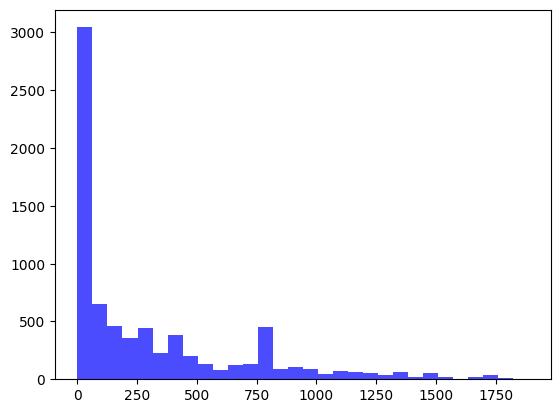

In [36]:
plt.hist(degree_sequence, bins=30, color='blue', alpha=0.7)
print(f"Average degree: {sum(degree_sequence)/len(degree_sequence)}")